# Using BERT-Base-Uncased for D-FJ and FactJudge

### Importing necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import csv
import time
import datetime
import itertools
from tqdm import tqdm, trange

%matplotlib inline

### Checking if GPU available


In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'{torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1 GPU(s) available.
Device name: Tesla T4


### Downloading and Importing Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# mqpa_path = "/content/gdrive/My Drive/MPQAYahoo/mpqa"
# yahoo_path = "/content/gdrive/My Drive/MPQAYahoo/yahoo120"

# # Importing data from mqpa
# mqpa_train_df = pd.DataFrame(columns=['Sentence', 'O/F', 'Label', 'Document No.'])
# for i in trange(1, 536):
#   new_df = pd.read_csv(f'{mqpa_path}/hits_{i}.csv').dropna()
#   new_df['Document No.'] = i
#   new_df['Label'] = new_df['O/F'].map({'o': 0, 'f': 1}).astype('int64')
#   mqpa_train_df = pd.concat([mqpa_train_df, new_df])

# yahoo_train_df = pd.DataFrame(columns=['Sentence', 'O/F', 'Label', 'Document No.'])
# for i in trange(1, 121):
#   new_df = pd.read_csv(f'{yahoo_path}/hits_{i}.csv').dropna()
#   new_df['Document No.'] = i
#   new_df['Label'] = new_df['O/F'].map({'o': 0, 'f': 1}).astype('int64')
#   yahoo_test_df = pd.concat([yahoo_test_df, new_df])
#   yahoo_train_df = pd.concat([yahoo_train_df, new_df])

# mqpa_train_df['Collection'] = 'MQPA'
# yahoo_train_df['Collection'] = 'Yahoo'

# train_df = pd.concat([mqpa_train_df, yahoo_train_df])
# train_df.sample(10)

In [ ]:
sentences_df = pd.read_csv("/content/gdrive/My Drive/SentencesLabeling/labeled_sentences.csv")
sentences_df.head(10)

,Sentence,Label,Subcat
0,We have investigated the electronic structure ...,1,METHOD|MATERIAL
1,"It was found that the Sn valence states (5s, 5...",1,METHOD
2,It was demonstrated that the metallic states a...,1,MATERIAL
3,We discuss the nature of the electronic states...,0,O
4,ar X\niv :1\n10 7.,0,O
5,34 11\nv1 [\nco nd\n-m at\n.m tr\nlsc\ni] 1\n8...,1,METHOD|MATERIAL
6,"Lukoyanov∗,∗∗, E. Z.Kurmaev∗, L.D.",0,O
7,"Finkelstein∗, A.Moewes+\n+Department of Physic...",1,METHOD|MATERIAL
8,"It was found that the Sn valence states (5s, 5...",1,METHOD
9,It was demonstrated that the metallic states a...,1,MATERIAL


In [ ]:
# len(sentences_df)

In [ ]:
sentences_df = sentences_df.dropna()
# len([sentence for sentence in list(sentences_df["Sentence"]) if sentence.startswith("b'")])

In [ ]:
# sentences_df["Label"].describe()

### Importing BERT Model Requirements

In [ ]:
!pip install transformers

from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F

     |████████████████████████████████| 1.9MB 18.1MB/s 
     |████████████████████████████████| 3.2MB 51.2MB/s 
     |████████████████████████████████| 890kB 57.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=cbf63af5d4ab8f18913fa8c8904ec08e17091dbee094cc267d6971187e2dae7b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Importing sklearn requirements

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve

### BERT Preprocessing

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def preprocess_bert(data):
  encoded = tokenizer.encode_plus(
      text = data,
      add_special_tokens = True,
      max_length = MAX_LEN,
      pad_to_max_length = True,
      return_attention_mask = True,
      truncation=True
  )

  return encoded.get('input_ids'), encoded.get('attention_mask')

Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors


(array([4.308e+04, 3.611e+03, 3.530e+02, 1.220e+02, 3.700e+01, 9.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([  3. ,  60.6, 118.2, 175.8, 233.4, 291. , 348.6, 406.2, 463.8,
        521.4, 579. ]),
 <a list of 10 Patch objects>)

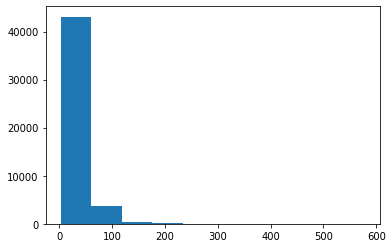

In [ ]:
all_sentences = list(sentences_df["Sentence"])
encoded_sents = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sentences]
plt.hist([len(sent) for sent in encoded_sents])

In [ ]:
MAX_LEN = 128
sentences_df['input_ids'], sentences_df['attention_mask'] = zip(*sentences_df['Sentence'].apply(preprocess_bert))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Separating preprocessed data

In [ ]:
# mqpa_group = mqpa_train_df.groupby('Document No.')
# mqpa_inputids_document_wise = mqpa_group['input_ids'].apply(np.array)
# mqpa_masks_document_wise = mqpa_group['attention_mask'].apply(np.array)
# mqpa_ytrain_document_wise = mqpa_group['Label'].apply(np.array)

# yahoo_group = yahoo_train_df.groupby('Document No.')
# yahoo_inputids_document_wise = yahoo_group['input_ids'].apply(np.array)
# yahoo_masks_document_wise = yahoo_group['attention_mask'].apply(np.array)
# yahoo_ytrain_document_wise = yahoo_group['Label'].apply(np.array)

### Fixed Random State

In [ ]:
RANDOM_STATE = 42

### Creating the final model

In [ ]:
%%time

class BertClassifier(nn.Module):
  def __init__(self, freeze_bert=False, RNNLayer='RNN', activation='Sigmoid', hidden_nodes=50):
    super(BertClassifier, self).__init__()

    D_in, H, D_out = 768, hidden_nodes, 2
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    if RNNLayer == 'RNN':
      self.rnn = nn.RNN(D_in, H, batch_first = True)
    elif RNNLayer == 'LSTM':
      self.rnn = nn.LSTM(D_in, H, batch_first = True)
    self.linear = nn.Linear(D_in, D_out)
    if activation == 'Sigmoid':
      self.activation = nn.Sigmoid()
    elif activation == 'ReLU':
      self.activation = nn.ReLU()
    elif activation == 'Tanh':
      self.activation = nn.Tanh()

    modules = [self.bert.embeddings, *self.bert.encoder.layer[:2]]
    if freeze_bert:
      for module in modules:
        for param in module.parameters():
          param.requires_grad = False
  
  def forward(self, input_ids, attention_masks):

    outputs = self.bert(input_ids=input_ids, attention_mask=attention_masks)
    last_hidden_state = outputs[0][:, 0, :]
    # rnn_out, _ = self.rnn(last_hidden_state)
    # activated = self.activation(rnn_out[:, -1, :])
    # logits = self.linear(rnn_out[:, -1, :])
    logits = self.linear(last_hidden_state)
    return logits

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.1 µs


### Train Test k-fold splitting

In [ ]:
def KFoldIds(X_train, labels, k=5):
  kf = StratifiedKFold(n_splits=k, random_state=RANDOM_STATE, shuffle=True)

  train_test_splits = []
  for train_index, test_index in kf.split(X_train, labels): # splitting in ratio of documents
    # arrays containing arrays of sentences in each document
    train_test_splits.append((train_index, test_index))
  
  return train_test_splits

def create_train_test_datasets(input_ids, masks, labels, k=5):
  input_ids_final = []
  masks_final = []
  labels_final = []
  input_ids_final_test = []
  masks_final_test = []
  labels_final_test = []

  train_test_splits = KFoldIds(input_ids, labels, k)
  for train_index, test_index in train_test_splits:
    input_ids_tr, input_ids_test = input_ids[train_index], input_ids[test_index]
    masks_tr, masks_test = masks[train_index], masks[test_index]
    labels_tr, labels_test = labels[train_index], labels[test_index]
    # concatenate all arrays together for training purpose
    input_ids_tensor = torch.tensor(list(input_ids_tr))
    masks_tensor = torch.tensor(list(masks_tr))
    labels_tensor = torch.tensor(list(labels_tr))
    input_ids_tensor_test = torch.tensor(list(input_ids_test))
    masks_tensor_test = torch.tensor(list(masks_test))
    labels_tensor_test = torch.tensor(list(labels_test))
    # store all the divided parts for reusing again and again
    input_ids_final.append(input_ids_tensor)
    masks_final.append(masks_tensor)
    labels_final.append(labels_tensor)
    input_ids_final_test.append(input_ids_tensor_test)
    masks_final_test.append(masks_tensor_test)
    labels_final_test.append(labels_tensor_test)
  
  return input_ids_final, masks_final, labels_final, input_ids_final_test, masks_final_test, labels_final_test

## Model initializer and scheduler

In [ ]:
def initialize_model(RNNLayer='RNN', activation='Sigmoid'):
  # Instantiate Bert Classifier
  bert_classifier = BertClassifier(freeze_bert=True, RNNLayer=RNNLayer, activation=activation)

  # Tell PyTorch to run the model on GPU
  bert_classifier.to(device)

  # Create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
                    lr=5e-5,    
                    eps=1e-8   
                    )
  
  return bert_classifier, optimizer

def get_scheduler(train_dataloader, optimizer, epochs=4):
  # Total number of training steps
  total_steps = len(train_dataloader) * epochs

  # Set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0, 
                                              num_training_steps=total_steps)
  return scheduler

### Training method for a combination of hyperparameters

In [ ]:
%%time

def train(model, train_dataloader, optimizer, scheduler, epochs=4, test_ids = None, test_masks = None, test_labels = None):
  print("Start training...")
  # loss_fn = nn.BCELoss()
  loss_fn=nn.CrossEntropyLoss()
  for epoch_i in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Elapsed':^9}")
    print('-'*50)

    t0_epoch, t0_batch = time.time(), time.time()
    total_loss, batch_loss, batch_counts = 0, 0, 0

    # Put the model into the training mode
    model.train()
    for step, batch in enumerate(train_dataloader):
      batch_counts +=1
      # Load batch to GPU
      b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

      # Zero out any previously calculated gradients
      model.zero_grad()

      # Perform a forward pass. This will return logits.
      logits = model(b_input_ids, b_attn_mask)

      # Compute loss and accumulate the loss values
      # loss = loss_fn(logits, b_labels.to(torch.float32).unsqueeze(1))
      loss = loss_fn(logits, b_labels)
      batch_loss += loss.item()
      total_loss += loss.item()

      # Perform a backward pass to calculate gradients
      loss.backward()

      # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and the learning rate
      optimizer.step()
      scheduler.step()

      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
        # Calculate time elapsed for 20 batches
        time_elapsed = time.time() - t0_batch

        # Print training results
        print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()
      
    all_probs = bert_predict(model, test_ids, test_masks, test_labels)
    all_probs = F.softmax(torch.cat(all_probs), dim=1).cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(np.array(test_labels), all_probs[:, 1])
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    accuracy = accuracy_score(np.array(test_labels), np.where(all_probs[:,1]>=thresholds[ix], 1, 0))

    csv_file = open('/content/gdrive/My Drive/SentencesLabeling/freeze_bert_2_32.csv', mode='a')
    csv_write = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_write.writerow([epoch_i, precision[ix], recall[ix], accuracy, thresholds[ix]])
    csv_file.close()
    
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average Train Loss: {avg_train_loss}')

    # Printing results for these hyperparameters
    print(f"{'Epochs':^10} | {'Precision':^15} | {'Recall':^15} | {'Accuracy':^15} | {'Threshold':^15}")

    print(f"{epoch_i:^10} | {precision[ix]:^15.2f} | {recall[ix]:^15.2f} | {accuracy:^15.2f} | {thresholds[ix]:^15.2f}")
  return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [ ]:
def set_seed(seed_value=42):
  """Set seed for reproducibility.
  """
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

### Predict with trained model

In [ ]:
def bert_predict(model, input_ids, masks, labels):
  test_data = TensorDataset(input_ids, masks, labels)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)


  all_probs=[]
  for batch in test_dataloader:
    # Load batch to GPU
    b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

    # Compute logits
    with torch.no_grad():
      probs = model(b_input_ids, b_attn_mask)
    all_probs.append(probs)

  return all_probs

In [ ]:
def train_loop():
  
  k = 5

  input_ids_final, masks_final, labels_final, \
    input_ids_final_test, masks_final_test, labels_final_test = \
    create_train_test_datasets(np.array(sentences_df["input_ids"]), np.array(sentences_df["attention_mask"]), np.array(sentences_df["Label"]))

  RNNLayers = ['LSTM']
  batch_sizes = [32]
  epochs_s = [10]
  activations = ['Sigmoid']

  for RNNLayer, batch_size, epochs, activation in list(itertools.product(RNNLayers, batch_sizes, epochs_s, activations)):

    time0 = time.time()

    print(f"{'Model':^7} | {'Activation':^15} {'Batch Size':^15} | {'Epochs':^10}")
    print(f"{RNNLayer:^7} | {activation:^15} {batch_size:^15} | {epochs:^10}")

    for i in range(1, k):

      train_data = TensorDataset(input_ids_final[i], masks_final[i], labels_final[i])
      train_sampler = RandomSampler(train_data)
      train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

      bert_classifier, optimizer = initialize_model(RNNLayer=RNNLayer, activation=activation)
      scheduler = get_scheduler(train_dataloader, optimizer, epochs=epochs)
      model = train(bert_classifier, train_dataloader, optimizer, scheduler, epochs, 
                    input_ids_final_test[i], masks_final_test[i], labels_final_test[i])

    time_end = time.time()

    train_time = datetime.timedelta(seconds=time_end-time0)

In [ ]:
set_seed(42)
train_loop()

 Model  |   Activation      Batch Size    |   Epochs  
 LSTM   |     Sigmoid           32        |     10    



Start training...
 Epoch  |  Batch  |  Train Loss  |  Elapsed 
--------------------------------------------------
   1    |   20    |   0.574110   |   11.86  
   1    |   40    |   0.457225   |   11.52  
   1    |   60    |   0.431397   |   11.71  
   1    |   80    |   0.417954   |   12.06  
   1    |   100   |   0.377764   |   12.49  
   1    |   120   |   0.347607   |   12.48  
   1    |   140   |   0.315710   |   12.10  
   1    |   160   |   0.330451   |   11.91  
   1    |   180   |   0.322236   |   11.86  
   1    |   200   |   0.243194   |   11.95  
   1    |   220   |   0.253026   |   12.14  
   1    |   240   |   0.241429   |   12.19  
   1    |   260   |   0.265849   |   12.20  
   1    |   280   |   0.226242   |   12.14  
   1    |   300   |   0.250268   |   12.06  
   1    |   320   |   0.172867   |   12.01  
   1    |   340   |   0.168260   |   12.03  
   1    |   360   |   0.229025   |   12.09  
   1    |   380   |   0.193717   |   12.08  
   1    |   400   |   0.189433